# Reeb Graph Matching
#### Implementing 'Topology Matching for Fully Automatic Similarity Estimation of 3D Shapes'
#### http://graphics.stanford.edu/courses/cs468-08-fall/pdf/Hilaga01.pdf
#### (Hilaga et al., 2001)

In [1]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csd_functions
import scipy
import networkx as nx
import reeb_matching
from copy import deepcopy
sns.set()


Load tree data

In [2]:
prefix = 'gbarEvPyrAmpa_sweep'

data_dir = os.path.abspath('../lfp_reeb_github/data')
name = 'gbarEvPyrAmpa_sweep10'
node_points, node_connectivity = reeb_matching.load_tree(data_dir,prefix,name)


Compute multiresoluion reeb graph

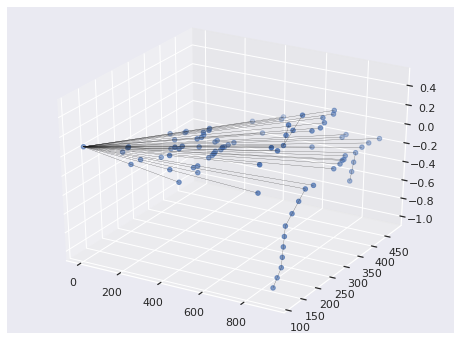

In [5]:
%matplotlib inline
G = nx.Graph()
G.add_edges_from(node_connectivity)

node_attributes = {node_id : {'Position' : node_points[node_id,:], 'Visited' : 0, 'Merged':[],'Inserted':[],'New_Merge':[]} for node_id in list(G.nodes)}
nx.set_node_attributes(G,node_attributes)

interval_dict = reeb_matching.compute_intervals(node_points, 16)

seed_node = list(G.nodes)[1]
reeb_matching.graph_search(G, seed_node, interval_dict,0)
reeb_matching.plot_graph(G)

G.clear()

Compute Similarity 

In [4]:
data_dir = os.path.abspath('../lfp_reeb_github/data')
prefix = 'gbarEvPyrAmpa_sweep'

s_dir = data_dir + '/' + prefix + '/' + 'skeleton/'
file_list = reeb_matching.get_skeleton_names(s_dir) # only first two for now

file_list

resolution_list = [4,2]

similarity_matrix, MPAIR_list = reeb_matching.tree_sim_matrix(file_list, resolution_list, data_dir, prefix)


0 0 tree_sim =  1.9375
{(1, 1, 4): {'R': 1, 'S': 1, 'Proportion': [0.03125, 0.03125], 'Resolution': 4}, (1, 1, 2): {'R': 1, 'S': 1, 'Proportion': [0.03125, 0.03125], 'Resolution': 2}, (94, 94, 4): {'R': 94, 'S': 94, 'Proportion': [0.03125, 0.03125], 'Resolution': 4}, (94, 94, 2): {'R': 94, 'S': 94, 'Proportion': [0.03125, 0.03125], 'Resolution': 2}, (78, 78, 4): {'R': 78, 'S': 78, 'Proportion': [0.03125, 0.03125], 'Resolution': 4}, (78, 78, 2): {'R': 78, 'S': 78, 'Proportion': [0.03125, 0.03125], 'Resolution': 2}, (65, 65, 4): {'R': 65, 'S': 65, 'Proportion': [0.03125, 0.03125], 'Resolution': 4}, (65, 65, 2): {'R': 65, 'S': 65, 'Proportion': [0.03125, 0.03125], 'Resolution': 2}, (107, 107, 4): {'R': 107, 'S': 107, 'Proportion': [0.03125, 0.03125], 'Resolution': 4}, (107, 107, 2): {'R': 107, 'S': 107, 'Proportion': [0.03125, 0.03125], 'Resolution': 2}, (117, 117, 4): {'R': 117, 'S': 117, 'Proportion': [0.03125, 0.03125], 'Resolution': 4}, (117, 117, 2): {'R': 117, 'S': 117, 'Proportion'

KeyboardInterrupt: 

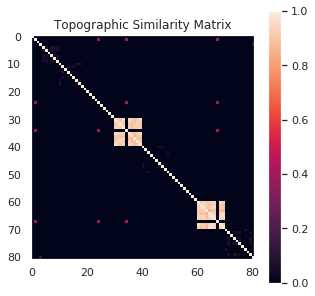

In [7]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid',{'axes.grid' : False})
plt.imshow(similarity_matrix,vmin=0, vmax=1)
plt.title('Topographic Similarity Matrix')
plt.colorbar()
plt.show()

Compare with wasserstein:

In [60]:
w_similarity_matrix = np.array(pd.read_csv('../data/gbarEvPyrAmpa_sweep/similarity_matrices/similarity_matrix_wasserstein.csv',header=None))
w_similarity_matrix = w_similarity_matrix/np.max(w_similarity_matrix)

#Make symmetric wrt upper triangle
i_lower = np.tril_indices(w_similarity_matrix.shape[0], -1)
w_similarity_matrix[i_lower] = w_similarity_matrix.T[i_lower]

EmptyDataError: No columns to parse from file

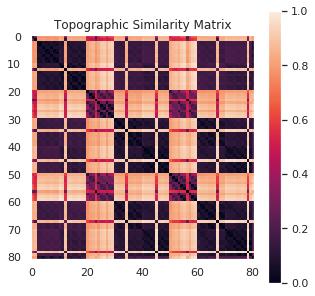

In [4]:
%matplotlib inline
plt.figure(figsize=(5,5))
sns.set_style('darkgrid',{'axes.grid' : False})
plt.imshow(w_similarity_matrix)
plt.title('Topographic Similarity Matrix')
plt.colorbar()
plt.show()

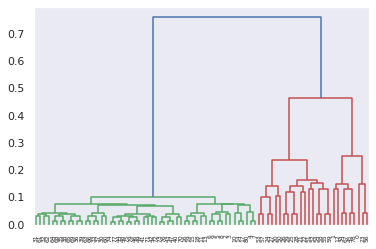

In [5]:
%matplotlib qt
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as hcluster
from matplotlib.pyplot import show

distVec = ssd.squareform(w_similarity_matrix)
linkage = hcluster.linkage(distVec)
plt.figure()
dendro  = hcluster.dendrogram(linkage)


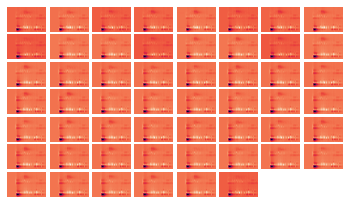

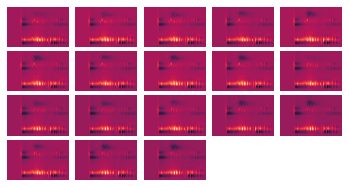

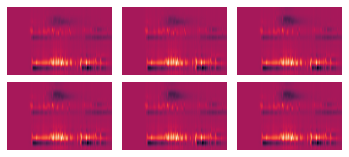

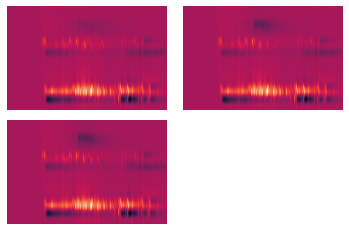

In [90]:
%matplotlib inline
cluster_indeces = hcluster.fcluster(linkage, t=4, criterion='maxclust')
cluster_labels = np.unique(cluster_indeces)
p_dir = '../lfp_reeb_github/data/gbarEvPyrAmpa_sweep/points'
file_list = np.array(os.listdir(p_dir)) 

for label in cluster_labels:
    file_cluster = file_list[cluster_indeces == label]
    num_files = len(file_cluster)
    num_rc = np.ceil(np.sqrt(num_files)).astype(int)

    count = 1
    plt.figure()
    for f in file_cluster:
        f_path = p_dir + '/' + f

        plt.subplot(num_rc,num_rc,count)
        csd_grid = csd_functions.points2grid(np.array(pd.read_csv(f_path)))
        plt.imshow(csd_grid,aspect='auto')
        plt.axis('off')
        
        count += 1
    
    # plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()




